# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import seaborn as sns
import math
from sklearn.metrics import brier_score_loss, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve, auc, \
                    precision_recall_curve, average_precision_score, confusion_matrix
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.shape

(143424, 26)

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [6]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [7]:
df.nunique()

encounter_id                101766
patient_nbr                  71518
race                             6
gender                           3
age                             10
weight                          10
admission_type_id                8
discharge_disposition_id        26
admission_source_id             17
time_in_hospital                14
payer_code                      18
medical_specialty               73
primary_diagnosis_code         717
other_diagnosis_codes        19374
number_outpatient               39
number_inpatient                21
number_emergency                33
num_lab_procedures             118
number_diagnoses                16
num_medications                 75
num_procedures                   7
ndc_code                       251
max_glu_serum                    4
A1Cresult                        4
change                           2
readmitted                       3
dtype: int64

In [8]:
#Line Test
try:
    assert len(df) > df['encounter_id'].nunique()
    print("Dataset could be at the line level")
except:
    print("Dataset is not at the line level")

Dataset could be at the line level


In [9]:
#Encounter Test
try:
    assert len(df)  == df['encounter_id'].nunique()
    print("Dataset could be at the encounter level")
except:
    print("Dataset is not at the encounter level")

Dataset is not at the encounter level


In [10]:
# Longitudinal Test
try:
    assert len(df) == df['patient_nbr'].nunique()
    print("Dataset could be at the longitudinal level")
except:
    print("Dataset is not at the longitudinal level")

Dataset is not at the longitudinal level


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response: 
The dataset is at the line level based on the EDA above. 

I don't see any other fields that we can use to aggregate to determine line/encounter lelves besides encounter_Id and patient_nbr.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    
#### See student's responses below

In [11]:
#Missing values
def check_for_missing_values(df):
    missing_df = pd.DataFrame({'columns': df.columns,
                              'percent_null': df.isnull().sum() * 100/len(df),
                               'percent_zero': df.isin([0]).sum() * 100/len(df),
                               'percent_none': df.isin(["None"]).sum() * 100/len(df),
                               'percent_question_mark': (df.applymap(lambda x: "?" in x.lower() if isinstance(x,str) else False).sum()) *100/len(df)
                              })
    return missing_df


In [12]:
null_missing_value_df = check_for_missing_values(df)
null_missing_value_df

,columns,percent_null,percent_zero,percent_none,percent_question_mark
encounter_id,encounter_id,0.00000,0.000000,0.000000,0.000000
patient_nbr,patient_nbr,0.00000,0.000000,0.000000,0.000000
race,race,0.00000,0.000000,0.000000,2.307145
gender,gender,0.00000,0.000000,0.000000,0.000000
age,age,0.00000,0.000000,0.000000,0.000000
weight,weight,0.00000,0.000000,0.000000,97.000502
admission_type_id,admission_type_id,0.00000,0.000000,0.000000,0.000000
discharge_disposition_id,discharge_disposition_id,0.00000,0.000000,0.000000,0.000000
admission_source_id,admission_source_id,0.00000,0.000000,0.000000,0.000000
time_in_hospital,time_in_hospital,0.00000,0.000000,0.000000,0.000000


Response To: a. Field(s) with high amount of missing/zero values

Fields with significant missing values (i.e. null, None, "?"): weight(97%), payer_code (37.78%), medical_specialty (48.43%),max_glu_serum (95.11%), A1Cresult (82.03%), ndc_code(16.36%)


In [13]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures
count,1.434240e+05,1.434240e+05,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000,143424.000000
mean,1.674290e+08,5.493608e+07,2.027694,3.655316,5.701096,4.490190,0.362429,0.600855,0.195086,43.255745,7.424434,16.776035,1.349021
std,1.019046e+08,3.857840e+07,1.427585,5.219279,4.064532,2.999667,1.249295,1.207934,0.920410,19.657319,1.924872,8.397130,1.719104
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,8.829596e+07,2.357219e+07,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,32.000000,6.000000,11.000000,0.000000
50%,1.547637e+08,4.630783e+07,1.000000,1.000000,7.000000,4.000000,0.000000,0.000000,0.000000,44.000000,8.000000,15.000000,1.000000
75%,2.320897e+08,8.823627e+07,3.000000,3.000000,7.000000,6.000000,0.000000,1.000000,0.000000,57.000000,9.000000,21.000000,2.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,42.000000,21.000000,76.000000,132.000000,16.000000,81.000000,6.000000


In [15]:
str_columns = list(df.select_dtypes(include='object').columns)
print("Categorical column names", str_columns)

Categorical column names ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'other_diagnosis_codes', 'ndc_code', 'max_glu_serum', 'A1Cresult', 'change', 'readmitted']


In [16]:
num_columns = list(set(columns) - set(str_columns))
print("Numeric column names", num_columns)

Numeric column names ['number_diagnoses', 'discharge_disposition_id', 'encounter_id', 'num_procedures', 'patient_nbr', 'num_lab_procedures', 'number_emergency', 'admission_source_id', 'number_inpatient', 'admission_type_id', 'time_in_hospital', 'number_outpatient', 'num_medications']


In [17]:
#Visualize categorical distributions
def visualize_distributions(df,c):
    df[c].value_counts().plot(kind='bar')
    plt.show()
    plt.close()

### Numeric Distributions

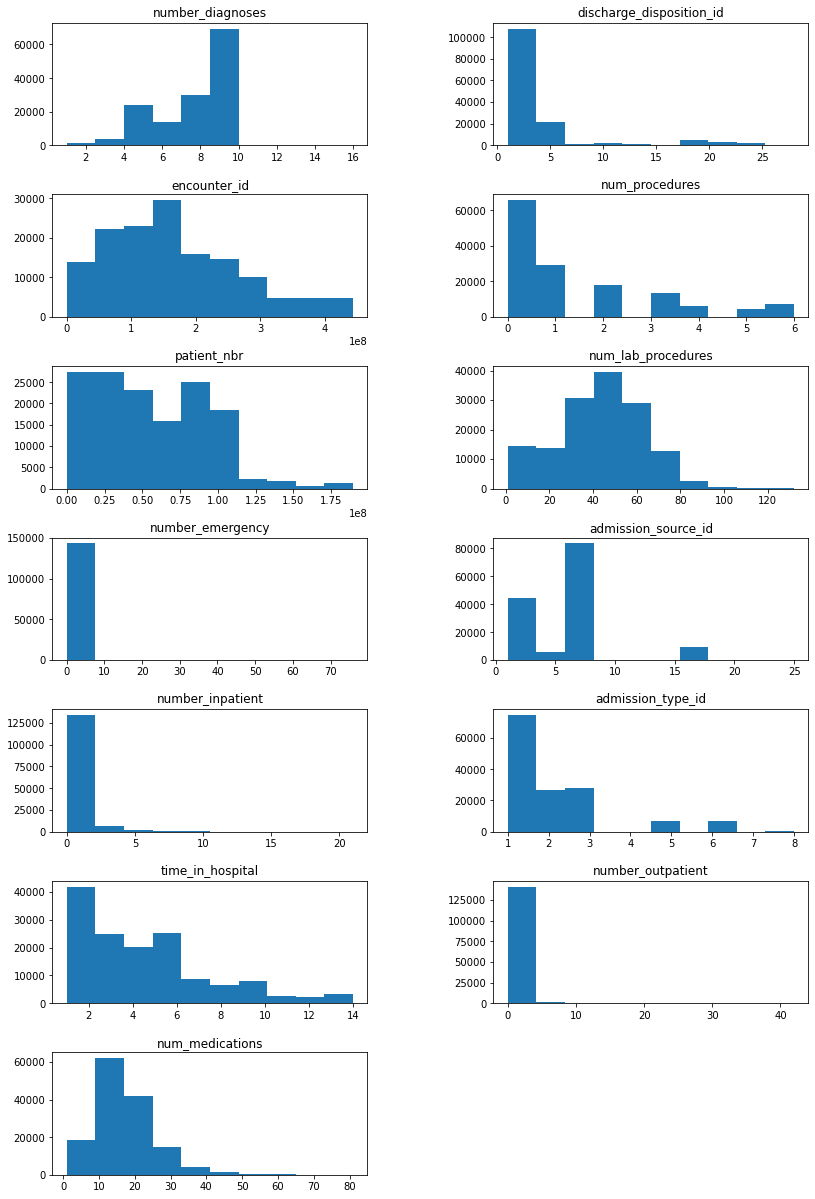

In [18]:
col_len = math.ceil(len(num_columns)/2)
fig, axs = plt.subplots(col_len,2, figsize=(15,20))
for (i, ax) in zip(range(len(num_columns)), axs.flatten()):
    col_name = num_columns[i]
    ax.hist(df[col_name])
    ax.set_title(col_name)
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.8,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
axs[6,1].set_axis_off()
plt.show()

Response to: Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?

- num_medications (skewed right)
- num_lab_procedures (skewed right)



### Categorical Distributions

In [19]:
str_columns.extend(['admission_type_id','discharge_disposition_id', 'admission_source_id'])
cardinality_df = pd.DataFrame({"column": str_columns, "cardinality": df[str_columns].nunique()})
cardinality_df.sort_values(by='cardinality', ascending=False)

,column,cardinality
other_diagnosis_codes,other_diagnosis_codes,19374
primary_diagnosis_code,primary_diagnosis_code,717
ndc_code,ndc_code,251
medical_specialty,medical_specialty,73
discharge_disposition_id,discharge_disposition_id,26
payer_code,payer_code,18
admission_source_id,admission_source_id,17
age,age,10
weight,weight,10
admission_type_id,admission_type_id,8


Response to: Which field(s) have high cardinality and why (HINT: ndc_code is one feature)

other_diagnosis_codes, primary_diagnosis_code and ndc_code seem to have highest cardinality. 
See table above.

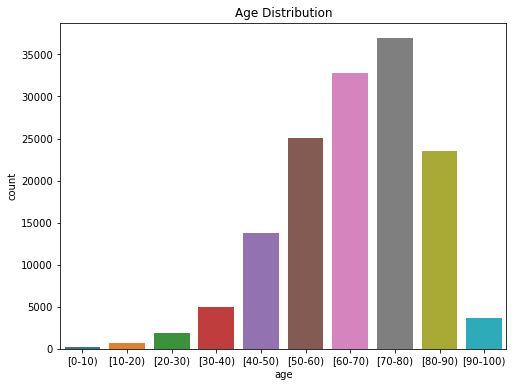

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(x='age', data=df)
plt.title('Age Distribution')
plt.show()

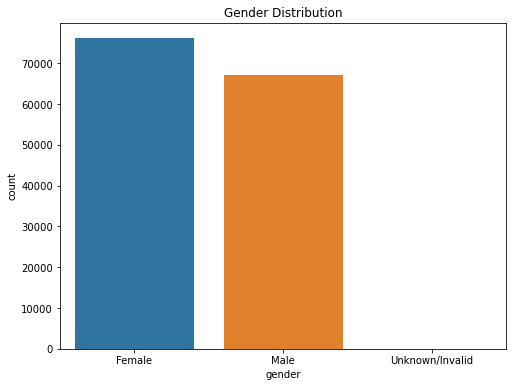

In [21]:
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.show()

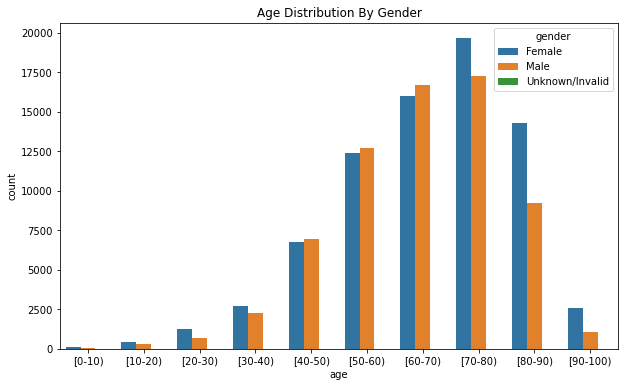

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age', hue="gender", data=df)
plt.title('Age Distribution By Gender')
plt.show()

In [23]:
df["gender"].value_counts()

Female             76185
Male               67234
Unknown/Invalid        5
Name: gender, dtype: int64

Response to: Please describe the demographic distributions in the dataset for the age and gender fields.
There are 76,185 females compared to 67,234 males in the dataset.
Most patients seem to be at 70-80 years old with more females than males as shown in chart above. Interestingly, between the ages of 40-70, more patients are males.


In [24]:
#Drop columns with high missing values( >50%)
#Fields with significant missing values (i.e. null, None, "?"): weight(97%), payer_code (37.78%), medical_specialty (48.43%),max_glu_serum (95.11%), A1Cresult (82.03%), ndc_code(16.36%)

df = df.drop(columns = ["weight","max_glu_serum","A1Cresult"])
    

In [25]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'change', 'readmitted'],
      dtype='object')

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

In [2]:
# ######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [27]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [28]:
ndc_code_df

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
...,...,...,...,...,...,...,...
264,0781-5635,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
265,64764-302,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
266,64764-304,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
267,66993-821,Pioglitazone And Glimepiride,Pioglitazone And Glimepiride,Tablet,Oral,Prasco Laboratories,Human Prescription Drug


In [29]:
from student_utils import reduce_dimension_ndc

In [30]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [31]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,Ch,>30,Novolin R
1,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,Ch,NO,Novolin R
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,Ch,NO,Novolin R
3,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,Ch,NO,Novolin R
4,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,No,>30,Novolin R


In [32]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [33]:
print("Unique ndc_code", reduce_dim_df['ndc_code'].nunique())
print("Unique generic drug", reduce_dim_df['generic_drug_name'].nunique())

Unique ndc_code 251
Unique generic drug 36


## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [34]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [35]:
first_encounter_df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,change,readmitted,generic_drug_name
0,24437208,135,Caucasian,Female,[50-60),2,1,1,8,?,Cardiology,401,997|560,0,0,0,77,8,33,6,68071-1701,Ch,<30,Novolin R
1,189899286,729,Caucasian,Female,[80-90),1,3,7,4,MC,InternalMedicine,820,493|E880,0,0,0,68,9,23,2,0615-7982,No,NO,Metformin Hydrochloride
2,64331490,774,Caucasian,Female,[80-90),1,1,7,3,?,InternalMedicine,274,427|416,0,0,0,46,9,20,0,0115-1743,Ch,NO,Glyburide
3,14824206,927,AfricanAmerican,Female,[30-40),1,1,7,5,?,InternalMedicine,590,220|250,0,0,0,49,3,5,0,42571-104,No,NO,Glimepiride
4,8380170,1152,AfricanAmerican,Female,[50-60),1,1,7,6,?,Hematology/Oncology,282,250.01|?,0,1,0,43,2,13,2,47918-902,No,>30,Afrezza
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56128,359725880,189349430,Asian,Female,[70-80),1,1,7,1,MC,?,595,348|276,0,0,0,31,9,6,0,43063-630,No,NO,Glimepiride
56129,359719064,189365864,Other,Male,[60-70),1,1,7,3,HM,InternalMedicine,584,250.02|403,0,0,0,56,7,8,1,68071-1701,No,NO,Novolin R
56130,338462954,189445127,Caucasian,Female,[80-90),1,1,7,3,?,?,486,414|733,0,0,0,39,9,18,0,0378-1110,Ch,NO,Glipizide
56131,443811536,189481478,Caucasian,Female,[40-50),1,4,7,14,MD,?,295,305|250,0,0,0,69,5,16,0,68071-1701,Ch,>30,Novolin R


In [36]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [37]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [38]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [39]:
agg_drug_df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,change,readmitted,generic_drug_name_array,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide
0,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,?,?,398,427|38,0,0,0,68,8,28,2,0049-4110,Ch,NO,[Glucotrol],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15738,63555939,Caucasian,Female,[90-100),3,3,4,12,?,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,Ch,NO,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,68071-1701,Ch,NO,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,28236,89869032,AfricanAmerican,Female,[40-50),1,1,7,9,?,?,250.7,403|996,0,0,0,47,9,17,2,68071-1701,No,>30,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,?,?,414,411|250,0,0,0,31,9,16,6,47918-902,No,>30,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56128,443842016,183087545,Caucasian,Female,[70-80),1,1,7,9,?,?,574,574|250.02,0,0,0,50,9,33,2,47918-902,Ch,>30,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56129,443842022,188574944,Other,Female,[40-50),1,1,7,14,MD,?,592,599|518,0,0,1,73,9,26,6,68071-1701,Ch,>30,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
56130,443842070,140199494,Other,Female,[60-70),1,1,7,2,MD,?,996,585|403,1,1,1,46,9,17,6,47918-902,No,>30,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56131,443842136,181593374,Caucasian,Female,[70-80),1,1,7,5,?,?,491,518|511,0,1,0,21,9,16,1,68071-1701,No,NO,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: 
- Removing columns: "weight","max_glu_serum","A1Cresult"  as they have than 50% missing values.
- Removing "race" rows with "?"
- Removing "primary_diagnosis_code" with "?"
- Also removing "medical_specialty" and "payer_code" as they have to close to 50% missig values.

We can take out some fields such as number_outpatient and number_inpatient as we are taking the first encounters only.


In [40]:
agg_drug_df = agg_drug_df.drop(columns=["medical_specialty","payer_code"])

In [41]:
agg_drug_df["race"].value_counts()

Caucasian          41766
AfricanAmerican    10292
?                   1593
Hispanic            1168
Other                944
Asian                370
Name: race, dtype: int64

In [42]:
race_bad_idx = agg_drug_df[agg_drug_df["race"] == "?"].index
agg_drug_df= agg_drug_df.drop(race_bad_idx)

In [43]:
pcode_bad_idx =agg_drug_df[agg_drug_df["primary_diagnosis_code"] == "?"].index
agg_drug_df = agg_drug_df.drop(pcode_bad_idx)

In [44]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = ["primary_diagnosis_code", "admission_type_id","discharge_disposition_id", "admission_source_id"
                               ] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ["num_lab_procedures","number_diagnoses", "num_medications","num_procedures"]

PREDICTOR_FIELD = 'time_in_hospital'


In [45]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [46]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

In [47]:
selected_features_df.head()

,patient_nbr,time_in_hospital,primary_diagnosis_code,admission_type_id,discharge_disposition_id,admission_source_id,race,gender,age,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide,num_lab_procedures,number_diagnoses,num_medications,num_procedures
0,48330783,13,398,2,1,4,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,8,28,2
1,63555939,12,434,3,3,4,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,33,8,18,3
2,42519267,1,197,1,1,7,Caucasian,Male,[40-50),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,51,5,8,0
3,89869032,9,250.7,1,1,7,AfricanAmerican,Female,[40-50),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,47,9,17,2
4,82637451,3,414,2,1,2,Caucasian,Male,[50-60),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,9,16,6


### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?
Zero can have significantly value in context. Arbitrarily assigning 0 can inadvertantly introduce biases. Imputed values can be based on averaged values or other statistically more relevant calculated values.


In [48]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [49]:
processed_df.head()

,patient_nbr,time_in_hospital,primary_diagnosis_code,admission_type_id,discharge_disposition_id,admission_source_id,race,gender,age,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide,num_lab_procedures,number_diagnoses,num_medications,num_procedures
0,48330783,13.0,398,2,1,4,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,8,28,2
1,63555939,12.0,434,3,3,4,Caucasian,Female,[90-100),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,33,8,18,3
2,42519267,1.0,197,1,1,7,Caucasian,Male,[40-50),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,51,5,8,0
3,89869032,9.0,250.7,1,1,7,AfricanAmerican,Female,[40-50),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,47,9,17,2
4,82637451,3.0,414,2,1,2,Caucasian,Male,[50-60),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,9,16,6


In [50]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [51]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [52]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     7315
2.0     9218
3.0     9729
4.0     7454
5.0     5416
6.0     3989
7.0     3142
8.0     2353
9.0     1608
10.0    1256
11.0    1022
12.0     793
13.0     687
14.0     550
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


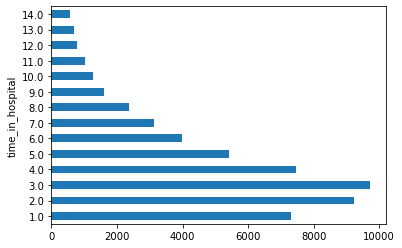

In [53]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     4365
2.0     5553
3.0     5818
4.0     4520
5.0     3201
6.0     2368
7.0     1903
8.0     1398
9.0      984
10.0     742
11.0     614
12.0     478
13.0     445
14.0     330
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


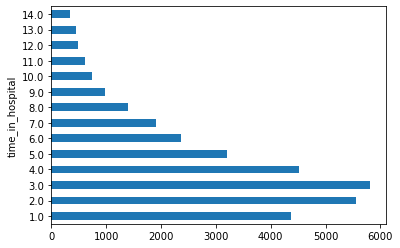

In [54]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     1489
2.0     1838
3.0     1957
4.0     1469
5.0     1095
6.0      843
7.0      594
8.0      471
9.0      319
10.0     235
11.0     208
12.0     150
13.0     125
14.0     113
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


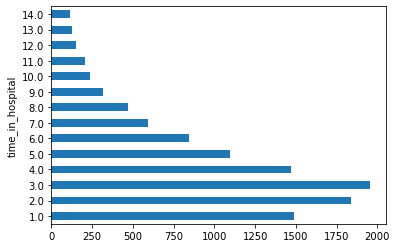

In [55]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             28787
Male               25744
Unknown/Invalid        1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


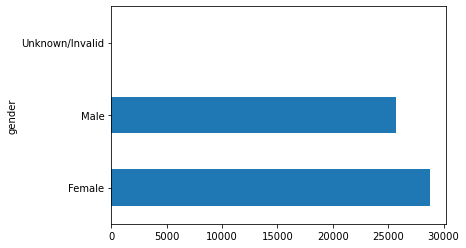

In [56]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    17247
Male      15472
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


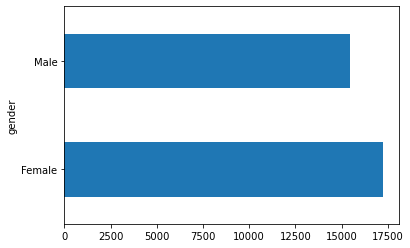

In [57]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    5767
Male      5139
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


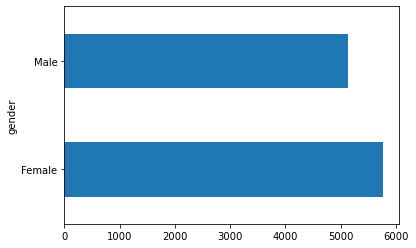

In [58]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [59]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [60]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [61]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [62]:
vocab_file_list

['./diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/admission_type_id_vocab.txt',
 './diabetes_vocab/discharge_disposition_id_vocab.txt',
 './diabetes_vocab/admission_source_id_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Afrezza_vocab.txt',
 './diabetes_vocab/Amaryl_vocab.txt',
 './diabetes_vocab/Avandia_2MG_vocab.txt',
 './diabetes_vocab/Avandia_4MG_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glucophage_vocab.txt',
 './diabetes_vocab/Glucophage_XR_vocab.txt',
 './diabetes_vocab/Glucotrol_vocab.txt',
 './diabetes_vocab/Glucotrol_XL_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydr

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [63]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 608 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 26 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 18 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 6 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:voca

In [64]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=608, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 609), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [65]:
%autoreload
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [66]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [67]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [68]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f3b13cae680>, mean=43.626211070020474, std=20.107281921638492))

tf.Tensor(
[[ 0.8 ]
 [-0.25]
 [ 1.55]
 [ 0.05]
 [-0.9 ]
 [ 0.5 ]
 [ 0.9 ]
 [ 1.75]
 [ 0.85]
 [-0.95]
 [-0.85]
 [-0.4 ]
 [ 0.15]
 [ 0.9 ]
 [-0.6 ]
 [ 0.45]
 [ 1.05]
 [-1.3 ]
 [-0.6 ]
 [-0.6 ]
 [ 0.  ]
 [-0.1 ]
 [ 0.7 ]
 [ 0.2 ]
 [ 0.5 ]
 [ 0.7 ]
 [ 1.  ]
 [ 0.05]
 [ 0.8 ]
 [ 1.85]
 [-2.1 ]
 [ 0.2 ]
 [ 1.7 ]
 [-0.15]
 [-2.1 ]
 [ 0.2 ]
 [ 0.3 ]
 [ 0.3 ]
 [ 0.05]
 [-1.1 ]
 [ 0.3 ]
 [-0.05]
 [ 0.25]
 [-0.15]
 [-0.15]
 [ 1.15]
 [ 1.35]
 [ 0.25]
 [ 0.25]
 [-1.95]
 [ 0.35]
 [-0.45]
 [ 0.8 ]
 [ 0.7 ]
 [-2.1 ]
 [-0.2 ]
 [-1.7 ]
 [ 0.3 ]
 [ 1.3 ]
 [ 2.05]
 [-0.1 ]
 [ 0.15]
 [ 0.25]
 [ 2.1 ]
 [-1.7 ]
 [-0.55]
 [ 1.4 ]
 [ 0.05]
 [-0.1 ]
 [-0.45]
 [-2.1 ]
 [-0.45]
 [ 0.6 ]
 [-0.9 ]
 [ 0.35]
 [ 0.1 ]
 [-0.75]
 [ 0.9 ]
 [ 0.25]
 [ 0.  ]
 [-0.1 ]
 

In [69]:
d_train

,patient_nbr,time_in_hospital,primary_diagnosis_code,admission_type_id,discharge_disposition_id,admission_source_id,race,gender,age,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,Tolbutamide,num_lab_procedures,number_diagnoses,num_medications,num_procedures
12584,90084420,2.0,733,2,3,1,AfricanAmerican,Female,[50-60),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,20,6,10,1
24019,43434207,3.0,553,1,3,7,Caucasian,Female,[80-90),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,54,7,13,2
17759,24627438,10.0,410,3,1,4,Caucasian,Male,[70-80),0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,46,8,57,3
2522,80201700,3.0,621,3,1,2,Caucasian,Female,[50-60),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,6,23,3
42092,100681776,3.0,428,1,1,7,Caucasian,Female,[70-80),0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,63,5,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31616,89732367,1.0,250.01,2,1,7,Caucasian,Female,[10-20),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,60,1,5,0
30466,101623248,4.0,250.8,1,1,2,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37,7,12,1
38808,106493994,1.0,414,1,2,7,Caucasian,Female,[60-70),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,32,9,9,0
16682,85052601,2.0,414,3,1,1,Caucasian,Female,[70-80),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,9,25,6


# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [70]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [71]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [72]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=30)

Train for 256 steps, validate for 86 steps
Epoch 1/30
256/256 [==============================] - 22s 86ms/step - loss: 28.9793 - mse: 28.9116 - val_loss: 24.8522 - val_mse: 24.7405
Epoch 2/30
256/256 [==============================] - 11s 45ms/step - loss: 21.6887 - mse: 21.3792 - val_loss: 19.8615 - val_mse: 19.4471
Epoch 3/30
256/256 [==============================] - 11s 44ms/step - loss: 15.5685 - mse: 14.8378 - val_loss: 13.7492 - val_mse: 12.2795
Epoch 4/30
256/256 [==============================] - 11s 44ms/step - loss: 13.8253 - mse: 12.9912 - val_loss: 15.0069 - val_mse: 14.0158
Epoch 5/30
256/256 [==============================] - 12s 46ms/step - loss: 12.3714 - mse: 11.5271 - val_loss: 13.3150 - val_mse: 12.3109
Epoch 6/30
256/256 [==============================] - 12s 47ms/step - loss: 10.9834 - mse: 9.9330 - val_loss: 11.4775 - val_mse: 10.3565
Epoch 7/30
256/256 [==============================] - 12s 48ms/step - loss: 11.0337 - mse: 10.2281 - val_loss: 10.3643 - val_mse: 

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [73]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [74]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [75]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [76]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,2.666495,5.0,5.195481,0.699570
1,4.170504,4.0,5.395185,0.699730
2,3.959200,2.0,3.356097,0.700313
3,2.566241,5.0,4.591232,0.698833
4,5.671429,3.0,2.597402,0.700139


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [77]:
%autoreload
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [78]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])


In [79]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head(10)

,patient_nbr,gender,race,time_in_hospital,score,label_value
17213,34128468,Female,Caucasian,5.0,1,1
7232,74472876,Female,Caucasian,4.0,1,0
48372,113373018,Female,Caucasian,2.0,0,0
21600,19985121,Female,Caucasian,5.0,0,1
42263,90640215,Female,Caucasian,3.0,0,0
51621,90764541,Male,Caucasian,3.0,1,0
39932,113942349,Male,Hispanic,3.0,0,0
19441,23757759,Male,Caucasian,2.0,0,0
42906,57893922,Female,Caucasian,3.0,0,0
7558,24040233,Male,Caucasian,3.0,0,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

### See responses below

In [91]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    return


def plot_roc_curve(ground_truth, probability):
    fpr, tpr, _ = roc_curve(ground_truth, probability)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr, color='darkorange', 
             lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()
    return

def plot_precision_recall_curve(ground_truth, probability):
    average_precision = average_precision_score(ground_truth, probability)
    precision, recall, _ = precision_recall_curve(ground_truth, probability)
    plt.figure(figsize=(7, 7))
    plt.plot(recall, precision, color='darkblue', 
             lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve')
    plt.show()
    return
    


In [81]:
# AUC, F1, precision and recall
# Summary
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      6753
           1       0.72      0.66      0.69      4153

    accuracy                           0.78     10906
   macro avg       0.76      0.75      0.76     10906
weighted avg       0.77      0.78      0.77     10906



In [82]:
print("Confusion Matrix")
tn,fp,fn,tp = confusion_matrix(pred_test_df['label_value'].values, pred_test_df['score'].values).ravel()
print(tp,fp, "\n", fn,tn)


Confusion Matrix
2743 1042 
 1410 5711


In [83]:
#F1 Score
f1_score(pred_test_df['label_value'], pred_test_df['score'], average='weighted')

0.7729398930478573

In [84]:
# AUC 
roc_auc_score(pred_test_df['label_value'], pred_test_df['score'])

0.7530923017902986

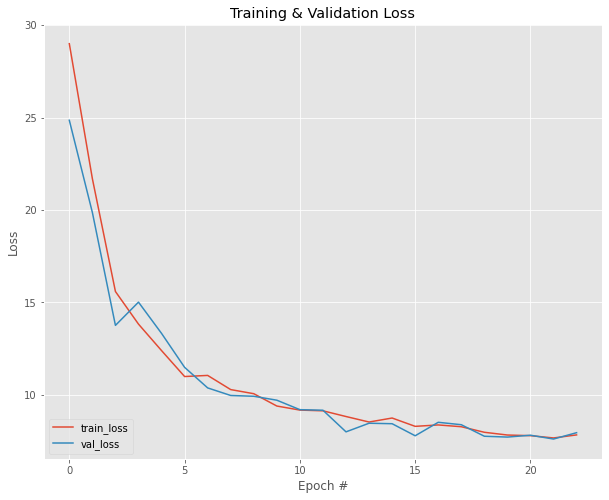

In [92]:
plot_history(history)

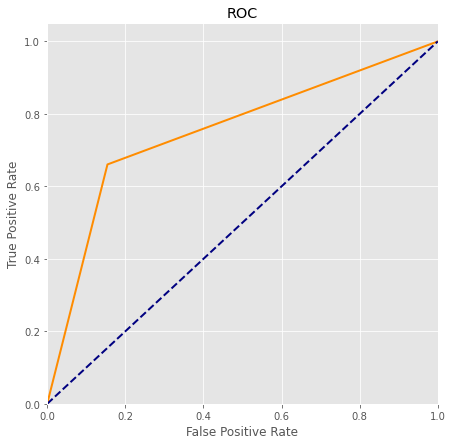

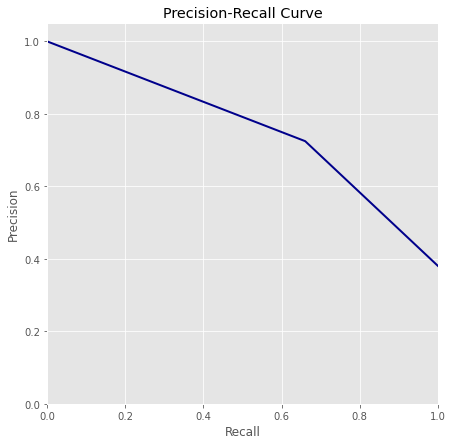

In [86]:
plot_roc_curve(pred_test_df['label_value'].values, pred_test_df['score'].values)
plot_precision_recall_curve(pred_test_df['label_value'].values, pred_test_df['score'].values)

### Responses to Q11:

- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.-
- What are some areas of improvement for future iterations?

Precision (TP/(TP +FP) measures the probability of sample classified as positive to actually be positive. Precision does not account for the false negatives. Thus a high precision can miss a lot of postive cases. In this model, the high precision can confirm the hospitalization time > 5 days.

The recall TP/(TP +FN) indicates the number of positives have been correctly classified out of all the  positives in the dataset. A high recall indicates that false negatives are low, so if a diagnosis, for example, is negative, it's likely to be negative. In our model, the high recall would confirm hospitalization time < 5 days. Recall does not take into account of false positives.

In minimizing the the false negatives to increase recall rate, we might increase the false positves thus lowering the precision rate. Like wise, minimizing the false positives to increase precision, we might increase the false negatives thus lowering the recall. Therefore, there is a trade-off between precision and recall.

F1 score is often used to average harmonically between precision and recall (F1 Score = (Precision x Recal)/(Precision + Recall)

For our model improvements, we can further improve on the architecture in terms of adding more layers, learning rates and finetune on the features. We can revisit on how the imputed values are calculated instead of generally replacing empty cells with zero.
I find that adding  'admission_type_id', 'discharge_disposition_id', 'admission_source_id' features improve the results overall.


https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba


# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [87]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [3785]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [88]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

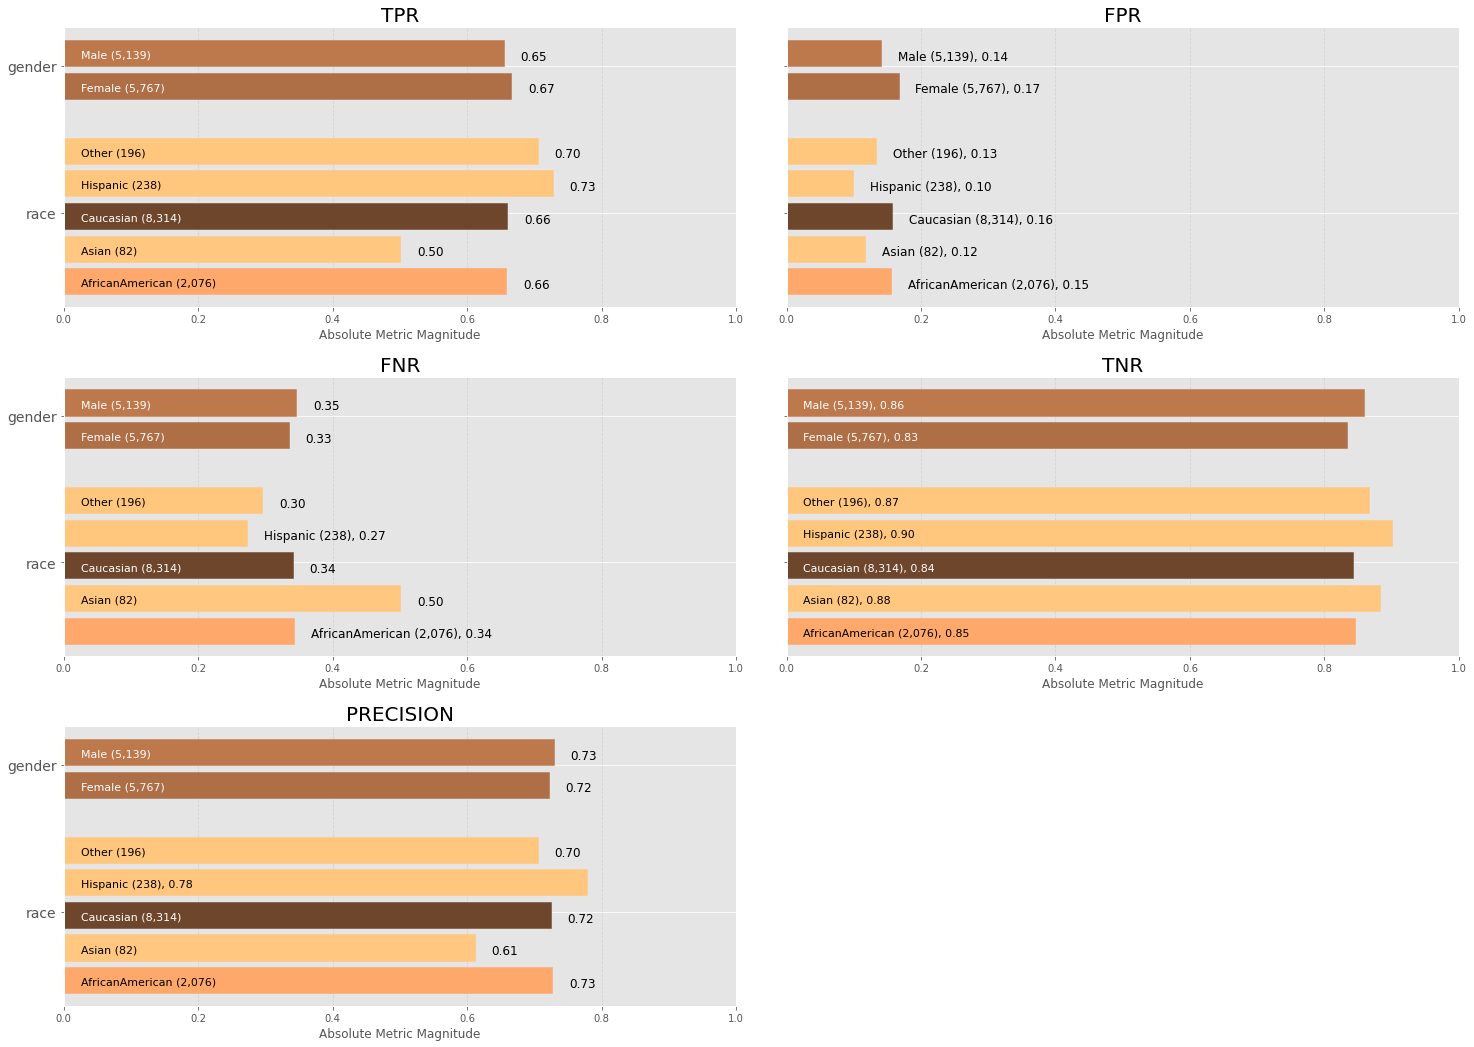

In [89]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?
p = aqp.plot_group_metric_all(clean_xtab, metrics=['tpr', 'fpr', 'fnr', 'tnr', 'precision'], ncols=2)

For the most part, there is no significant biases across the groups pertaining to gender and race. For FNR, Asian seems to be higher than other races indicating that their hostipalization is longer than the predicted 5 days. Females have more FPR than males indicating females are more falsely staying longer than 5 days compared to male patients.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

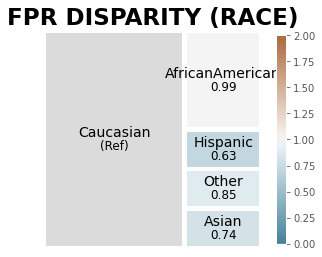

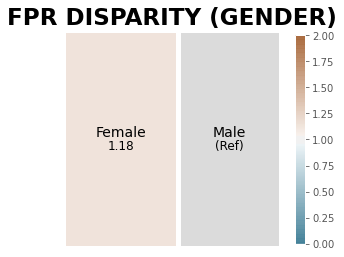

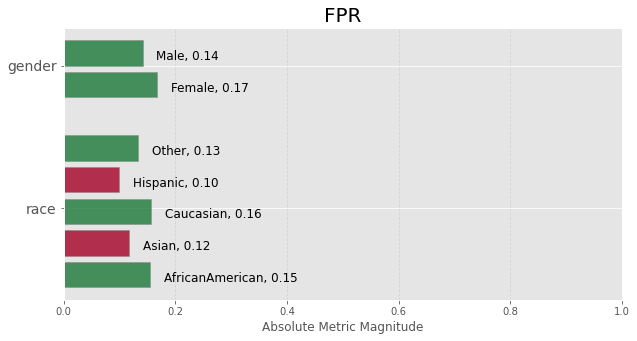

In [90]:
# # Reference group fairness plot
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='gender')
pr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)




Looking at the FPR disparity with Caucasian as reference, Asian, Hispanic and Other groups seem to  have lower FPR than Caucasian. Caucasians and African Americans which have about the same FPR indicating that they more likely to be falsely identified staying longer than 5 hospitalization days compared to other groups.

Additionally, the female group seems to have a higher FPR compared to the male counter part indicating that females are likely to be falsely identified staying longer that 5 hospitalization days.